# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [4]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [5]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

C:\Users\Евгений\AppData\Local\Temp\ipykernel_9892\3741198026.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
C:\Users\Евгений\AppData\Local\Temp\ipykernel_9892\3741198026.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat = test_X.reshape(test_X.sh

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [7]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [7]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([[-10, 0, 10])

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))

assert np.isclose(probs[0], 1.0)
print(linear_classifer.softmax(np.array([1.0001, 0, 0])),linear_classifer.softmax(np.array([0.9999, 0, 0])) ) 

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [5]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float64))

Gradient check passed!


В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [5]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
#Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

#Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float64)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


C:\Users\Евгений\AppData\Local\Temp\ipykernel_14028\2436061784.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
C:\Users\Евгений\AppData\Local\Temp\ipykernel_14028\2436061784.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; fo

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [4]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)
loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


C:\Users\Евгений\AppData\Local\Temp\ipykernel_908\1806627718.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
C:\Users\Евгений\AppData\Local\Temp\ipykernel_908\1806627718.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.random.randint(-1, 3, size=

True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [5]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [12]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

[autoreload of linear_classifer failed: Traceback (most recent call last):
  File "C:\Users\Евгений\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Евгений\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\extensions\autoreload.py", line 455, in superreload
    module = reload(module)
  File "C:\Users\Евгений\AppData\Local\Programs\Python\Python310\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "C:\Users\Евгений\dlcourse_ai\assignments\assignment1\li

(3073, 10)
Epoch 0, loss: 78.178582
Epoch 1, loss: 70.510608
Epoch 2, loss: 69.284558
Epoch 3, loss: 69.088457
Epoch 4, loss: 69.057089
Epoch 5, loss: 69.052071
Epoch 6, loss: 69.051269
Epoch 7, loss: 69.051140
Epoch 8, loss: 69.051120
Epoch 9, loss: 69.051116


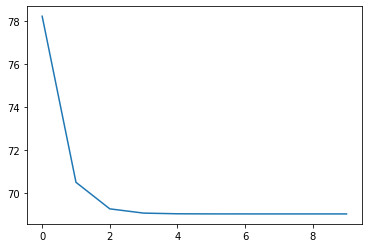

In [10]:
# let's look at the loss history!
plt.plot(loss_history)

In [35]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.123
(3073, 10)
Epoch 0, loss: 69.051116
Epoch 1, loss: 69.051116
Epoch 2, loss: 69.051116
Epoch 3, loss: 69.051116
Epoch 4, loss: 69.051116
Epoch 5, loss: 69.051116
Epoch 6, loss: 69.051116
Epoch 7, loss: 69.051116
Epoch 8, loss: 69.051116
Epoch 9, loss: 69.051116
Epoch 10, loss: 69.051116
Epoch 11, loss: 69.051116
Epoch 12, loss: 69.051116
Epoch 13, loss: 69.051116
Epoch 14, loss: 69.051116
Epoch 15, loss: 69.051116
Epoch 16, loss: 69.051116
Epoch 17, loss: 69.051116
Epoch 18, loss: 69.051116
Epoch 19, loss: 69.051116
Epoch 20, loss: 69.051116
Epoch 21, loss: 69.051116
Epoch 22, loss: 69.051116
Epoch 23, loss: 69.051116
Epoch 24, loss: 69.051116
Epoch 25, loss: 69.051116
Epoch 26, loss: 69.051116
Epoch 27, loss: 69.051116
Epoch 28, loss: 69.051116
Epoch 29, loss: 69.051116
Epoch 30, loss: 69.051116
Epoch 31, loss: 69.051116
Epoch 32, loss: 69.051116
Epoch 33, loss: 69.051116
Epoch 34, loss: 69.051116
Epoch 35, loss: 69.051116
Epoch 36, loss: 69.051116
Epoch 37, loss: 69.0

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [49]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None
classifiers = []
val_accuracy = []
# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
fitX_dataset = train_X[:int(train_X.shape[0] * 0.8)]
houldounX_dataset = train_X[:int(train_X.shape[0] * 0.2)]

fitY_dataset = train_y[:int(train_X.shape[0] * 0.8)]
houldounY_dataset = train_y[:int(train_X.shape[0] * 0.2)]

for i in learning_rates:
    for j in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(fitX_dataset,fitY_dataset,batch_size, i, j ,num_epochs)
        classifiers.append(classifier) 
        val_accuracy.append(multiclass_accuracy(classifier.predict(houldounX_dataset), houldounY_dataset))


(3073, 10)
Epoch 0, loss: 55.259173
Epoch 1, loss: 55.238530
Epoch 2, loss: 55.218905
Epoch 3, loss: 55.200015
Epoch 4, loss: 55.181667
Epoch 5, loss: 55.163729
Epoch 6, loss: 55.146106
Epoch 7, loss: 55.128735
Epoch 8, loss: 55.111572
Epoch 9, loss: 55.094585
Epoch 10, loss: 55.077753
Epoch 11, loss: 55.061060
Epoch 12, loss: 55.044496
Epoch 13, loss: 55.028051
Epoch 14, loss: 55.011721
Epoch 15, loss: 54.995501
Epoch 16, loss: 54.979387
Epoch 17, loss: 54.963377
Epoch 18, loss: 54.947468
Epoch 19, loss: 54.931659
Epoch 20, loss: 54.915948
Epoch 21, loss: 54.900333
Epoch 22, loss: 54.884813
Epoch 23, loss: 54.869387
Epoch 24, loss: 54.854053
Epoch 25, loss: 54.838811
Epoch 26, loss: 54.823659
Epoch 27, loss: 54.808597
Epoch 28, loss: 54.793622
Epoch 29, loss: 54.778735
Epoch 30, loss: 54.763935
Epoch 31, loss: 54.749219
Epoch 32, loss: 54.734588
Epoch 33, loss: 54.720041
Epoch 34, loss: 54.705576
Epoch 35, loss: 54.691193
Epoch 36, loss: 54.676891
Epoch 37, loss: 54.662669
Epoch 38, l

Epoch 111, loss: 53.788303
Epoch 112, loss: 53.778498
Epoch 113, loss: 53.768738
Epoch 114, loss: 53.759023
Epoch 115, loss: 53.749352
Epoch 116, loss: 53.739725
Epoch 117, loss: 53.730143
Epoch 118, loss: 53.720603
Epoch 119, loss: 53.711108
Epoch 120, loss: 53.701655
Epoch 121, loss: 53.692245
Epoch 122, loss: 53.682878
Epoch 123, loss: 53.673553
Epoch 124, loss: 53.664270
Epoch 125, loss: 53.655030
Epoch 126, loss: 53.645830
Epoch 127, loss: 53.636673
Epoch 128, loss: 53.627556
Epoch 129, loss: 53.618481
Epoch 130, loss: 53.609446
Epoch 131, loss: 53.600451
Epoch 132, loss: 53.591497
Epoch 133, loss: 53.582583
Epoch 134, loss: 53.573708
Epoch 135, loss: 53.564874
Epoch 136, loss: 53.556078
Epoch 137, loss: 53.547322
Epoch 138, loss: 53.538604
Epoch 139, loss: 53.529925
Epoch 140, loss: 53.521285
Epoch 141, loss: 53.512683
Epoch 142, loss: 53.504119
Epoch 143, loss: 53.495593
Epoch 144, loss: 53.487104
Epoch 145, loss: 53.478653
Epoch 146, loss: 53.470239
Epoch 147, loss: 53.461862
E

Epoch 19, loss: 55.221594
Epoch 20, loss: 55.219539
Epoch 21, loss: 55.217495
Epoch 22, loss: 55.215462
Epoch 23, loss: 55.213440
Epoch 24, loss: 55.211428
Epoch 25, loss: 55.209425
Epoch 26, loss: 55.207432
Epoch 27, loss: 55.205449
Epoch 28, loss: 55.203475
Epoch 29, loss: 55.201509
Epoch 30, loss: 55.199552
Epoch 31, loss: 55.197603
Epoch 32, loss: 55.195662
Epoch 33, loss: 55.193729
Epoch 34, loss: 55.191803
Epoch 35, loss: 55.189885
Epoch 36, loss: 55.187974
Epoch 37, loss: 55.186069
Epoch 38, loss: 55.184172
Epoch 39, loss: 55.182281
Epoch 40, loss: 55.180397
Epoch 41, loss: 55.178518
Epoch 42, loss: 55.176646
Epoch 43, loss: 55.174779
Epoch 44, loss: 55.172918
Epoch 45, loss: 55.171063
Epoch 46, loss: 55.169213
Epoch 47, loss: 55.167368
Epoch 48, loss: 55.165529
Epoch 49, loss: 55.163694
Epoch 50, loss: 55.161864
Epoch 51, loss: 55.160039
Epoch 52, loss: 55.158218
Epoch 53, loss: 55.156402
Epoch 54, loss: 55.154591
Epoch 55, loss: 55.152783
Epoch 56, loss: 55.150980
Epoch 57, lo

Epoch 130, loss: 55.027374
Epoch 131, loss: 55.025733
Epoch 132, loss: 55.024093
Epoch 133, loss: 55.022454
Epoch 134, loss: 55.020816
Epoch 135, loss: 55.019180
Epoch 136, loss: 55.017545
Epoch 137, loss: 55.015911
Epoch 138, loss: 55.014278
Epoch 139, loss: 55.012646
Epoch 140, loss: 55.011015
Epoch 141, loss: 55.009386
Epoch 142, loss: 55.007758
Epoch 143, loss: 55.006131
Epoch 144, loss: 55.004505
Epoch 145, loss: 55.002880
Epoch 146, loss: 55.001256
Epoch 147, loss: 54.999633
Epoch 148, loss: 54.998012
Epoch 149, loss: 54.996392
Epoch 150, loss: 54.994772
Epoch 151, loss: 54.993154
Epoch 152, loss: 54.991537
Epoch 153, loss: 54.989921
Epoch 154, loss: 54.988306
Epoch 155, loss: 54.986693
Epoch 156, loss: 54.985080
Epoch 157, loss: 54.983468
Epoch 158, loss: 54.981858
Epoch 159, loss: 54.980248
Epoch 160, loss: 54.978640
Epoch 161, loss: 54.977033
Epoch 162, loss: 54.975426
Epoch 163, loss: 54.973821
Epoch 164, loss: 54.972217
Epoch 165, loss: 54.970614
Epoch 166, loss: 54.969012
E

Epoch 39, loss: 55.254672
Epoch 40, loss: 55.254450
Epoch 41, loss: 55.254228
Epoch 42, loss: 55.254005
Epoch 43, loss: 55.253784
Epoch 44, loss: 55.253562
Epoch 45, loss: 55.253340
Epoch 46, loss: 55.253119
Epoch 47, loss: 55.252898
Epoch 48, loss: 55.252677
Epoch 49, loss: 55.252456
Epoch 50, loss: 55.252235
Epoch 51, loss: 55.252014
Epoch 52, loss: 55.251794
Epoch 53, loss: 55.251574
Epoch 54, loss: 55.251354
Epoch 55, loss: 55.251134
Epoch 56, loss: 55.250914
Epoch 57, loss: 55.250694
Epoch 58, loss: 55.250475
Epoch 59, loss: 55.250255
Epoch 60, loss: 55.250036
Epoch 61, loss: 55.249817
Epoch 62, loss: 55.249598
Epoch 63, loss: 55.249380
Epoch 64, loss: 55.249161
Epoch 65, loss: 55.248943
Epoch 66, loss: 55.248724
Epoch 67, loss: 55.248506
Epoch 68, loss: 55.248288
Epoch 69, loss: 55.248071
Epoch 70, loss: 55.247853
Epoch 71, loss: 55.247635
Epoch 72, loss: 55.247418
Epoch 73, loss: 55.247201
Epoch 74, loss: 55.246984
Epoch 75, loss: 55.246767
Epoch 76, loss: 55.246550
Epoch 77, lo

Epoch 149, loss: 55.228699
Epoch 150, loss: 55.228502
Epoch 151, loss: 55.228305
Epoch 152, loss: 55.228108
Epoch 153, loss: 55.227911
Epoch 154, loss: 55.227714
Epoch 155, loss: 55.227517
Epoch 156, loss: 55.227321
Epoch 157, loss: 55.227124
Epoch 158, loss: 55.226927
Epoch 159, loss: 55.226731
Epoch 160, loss: 55.226534
Epoch 161, loss: 55.226338
Epoch 162, loss: 55.226142
Epoch 163, loss: 55.225946
Epoch 164, loss: 55.225750
Epoch 165, loss: 55.225553
Epoch 166, loss: 55.225358
Epoch 167, loss: 55.225162
Epoch 168, loss: 55.224966
Epoch 169, loss: 55.224770
Epoch 170, loss: 55.224574
Epoch 171, loss: 55.224379
Epoch 172, loss: 55.224183
Epoch 173, loss: 55.223988
Epoch 174, loss: 55.223793
Epoch 175, loss: 55.223597
Epoch 176, loss: 55.223402
Epoch 177, loss: 55.223207
Epoch 178, loss: 55.223012
Epoch 179, loss: 55.222817
Epoch 180, loss: 55.222622
Epoch 181, loss: 55.222427
Epoch 182, loss: 55.222232
Epoch 183, loss: 55.222038
Epoch 184, loss: 55.221843
Epoch 185, loss: 55.221649
E

TypeError: must be real number, not NoneType

In [52]:
best_classifier = classifiers[0]
best_val_accuracy = val_accuracy[0]


best validation accuracy achieved: 0.232778
